In [1]:
import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

W0000 00:00:1758836799.745909  263533 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758836799.745925  263533 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758836799.745926  263533 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758836799.745927  263533 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
2025-09-26 00:46:39.749155: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other o

In [2]:
# 1032259319@pfur.ru -> 5931

# leave only those digits that are in the set [5,9,3,1]

train_idx = [i[0] for i in enumerate(y_train) if i[1] in [5,9,3,1]]
test_idx = [i[0] for i in enumerate(y_test) if i[1] in [5,9,3,1]]

x_train_filter = []
y_train_filter = []
for i in train_idx:
    x_train_filter.append(x_train[i])
    y_train_filter.append(y_train[i])
    
x_test_filter = []
y_test_filter = []
for i in test_idx:
    x_test_filter.append(x_test[i])
    y_test_filter.append(y_test[i])

x_train = x_train_filter
y_train = y_train_filter
x_test = x_test_filter
y_test = y_test_filter

In [3]:
import numpy as np
x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0
y_train = np.array(y_train)
y_test = np.array(y_test)

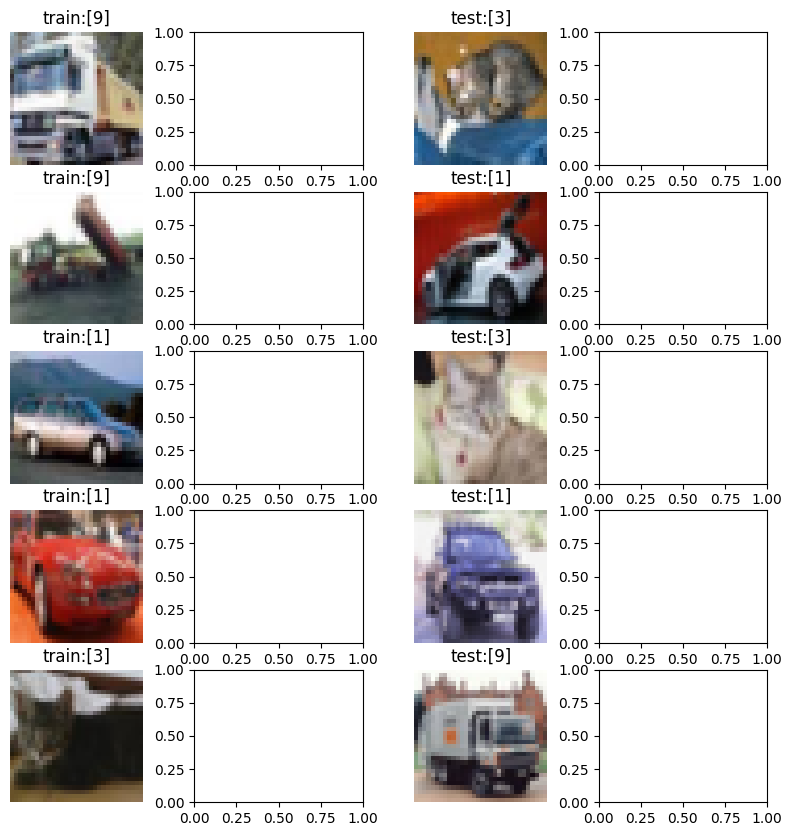

In [4]:
import matplotlib.pyplot as plt

# train images on left, test images on right
fig, axes = plt.subplots(5, 4, figsize=(10, 10))
for i in range(5):
    axes[i, 0].axis("off")
    axes[i, 2].axis("off")
    axes[i, 0].set_title('train:' + str(y_train[i]))
    axes[i, 2].set_title('test:' + str(y_test[i]))
    axes[i, 0].imshow(x_train[i])
    axes[i, 2].imshow(x_test[i])

In [5]:
import tensorflow as tf

class SamplingLayer(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
EMBEDDING_DIM = 128

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape


img_input = Input(shape=(32, 32, 3))
x = Conv2D(32, (3,3), strides=2, activation='relu', padding='same')(img_input)
x = Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = x.shape[1:]

x = Flatten()(x)
z_mean = Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = SamplingLayer()([z_mean, z_log_var])

encoder = keras.Model(img_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


I0000 00:00:1758836802.910083  263533 gpu_device.cc:2395] Ignoring visible gpu device (device: 1, name: AMD Radeon Graphics, pci bus id: 0000:11:00.0) with AMDGPU version : gfx1036. The supported AMDGPU versions are gfx900, gfx906, gfx908, gfx90a, gfx942, gfx950, gfx1030, gfx1100, gfx1101, gfx1102, gfx1200, gfx1201.
I0000 00:00:1758836802.982583  263533 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15030 MB memory:  -> device: 0, name: AMD Radeon RX 9070 XT, pci bus id: 0000:03:00.0


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 128)       │    262,272 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 128)       │    262,272 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_layer      │ (None, 128)       │          0 │ z_mean[0][0],     │
│ (SamplingLayer)     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 617,792 (2.36 MB)

 Trainable params: 617,792 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
import numpy as np


decoder_input = Input(shape=(EMBEDDING_DIM,))
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)
x = Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoder_output = Conv2D(
    3,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
)(x)

decoder = keras.Model(decoder_input, decoder_output)

In [8]:
autoencoder = keras.Model(img_input, decoder(encoder(img_input)[2]))

def ssim_loss(y_true, y_pred):
    return 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    
autoencoder.compile(optimizer=keras.optimizers.Adam(), loss=ssim_loss)

autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 128), (None,   │       617,792 │
│                                 │ 128), (None, 128)]     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 32, 32, 3)      │       504,899 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,122,691 (4.28 MB)

 Trainable params: 1,122,691 (4.28 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = autoencoder.fit(x_train, x_train, epochs=10, batch_size=128)

Epoch 1/10


I0000 00:00:1758836804.771097  263867 service.cc:152] XLA service 0x7ef9bc008550 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758836804.771111  263867 service.cc:160]   StreamExecutor device (0): AMD Radeon RX 9070 XT, AMDGPU ISA version: gfx1201
2025-09-26 00:46:44.805064: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-26 00:46:44.881828: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert/Assert
2025-09-26 00:46:44.881860: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert_1/Assert
2025-09-26 00:46:44.881962: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert_2/Assert
2025-09-26 00:46:44.882004: W tensorflow/compiler/tf2xla/kern

  3/157 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.9000 

I0000 00:00:1758836809.145784  263867 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.8054

2025-09-26 00:46:55.488959: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert/Assert
2025-09-26 00:46:55.488972: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert_1/Assert
2025-09-26 00:46:55.488991: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert_2/Assert
2025-09-26 00:46:55.488999: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert_3/Assert


157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - loss: 0.6509
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.3439
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.2705
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.2338
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.2112
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.1953
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.1850
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.1764
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.1696
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.1653


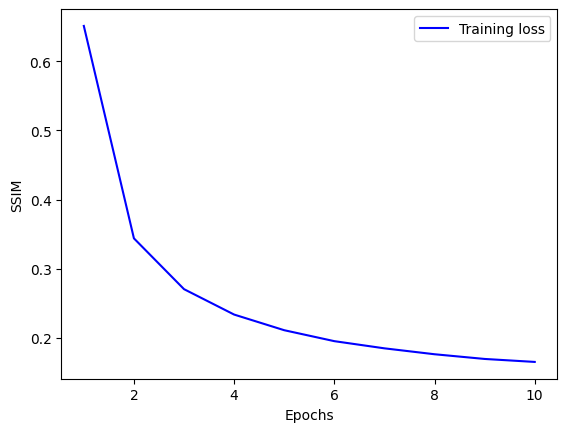

In [10]:
import matplotlib.pyplot as plt

loss = history.history["loss"]

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "b", label="Training loss")
plt.xlabel("Epochs")
plt.ylabel("SSIM")
plt.legend()
plt.show()

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


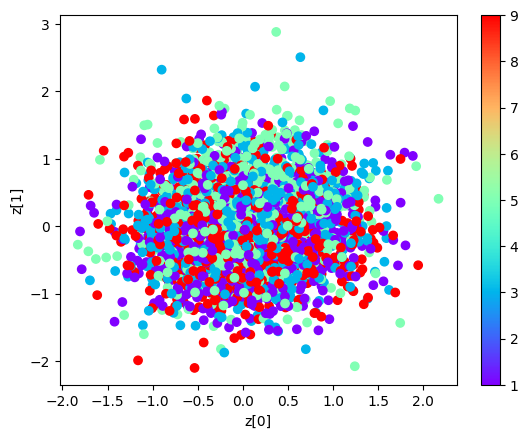

In [11]:
z_mean, z_log_var, z = encoder.predict(x_test)

plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='rainbow')
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


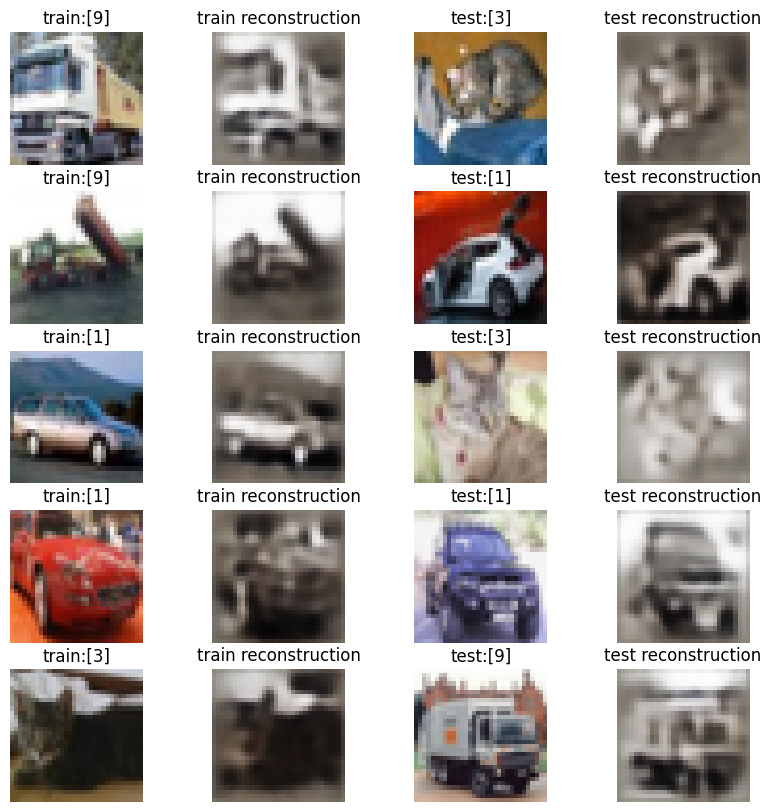

In [12]:
predictions_train = autoencoder.predict(x_train[:5])
predictions_test = autoencoder.predict(x_test[:5])
fig, axes = plt.subplots(5, 4, figsize=(10, 10))
for i in range(5):
    axes[i, 0].axis("off")
    axes[i, 2].axis("off")
    axes[i, 0].set_title('train:' + str(y_train[i]))
    axes[i, 2].set_title('test:' + str(y_test[i]))
    axes[i, 0].imshow(x_train[i])
    axes[i, 2].imshow(x_test[i])
    axes[i, 1].axis("off")
    axes[i, 3].axis("off")
    axes[i, 1].set_title('train reconstruction')
    axes[i, 3].set_title('test reconstruction')
    axes[i, 1].imshow(predictions_train[i])
    axes[i, 3].imshow(predictions_test[i])

In [13]:
idx1 = 0
idx2 = 0
max_dist = 0

for i in range(len(z)):
    for j in range(i + 1, len(z)):
        if max_dist > 50: break
        if y_test[i] == y_test[j]:
            continue
        dist = np.sum((z[i] - z[j]) ** 2)
        if dist > max_dist:
            max_dist = dist
            idx1 = i
            idx2 = j
            print(max_dist, idx1, idx2)


88.3343 0 1


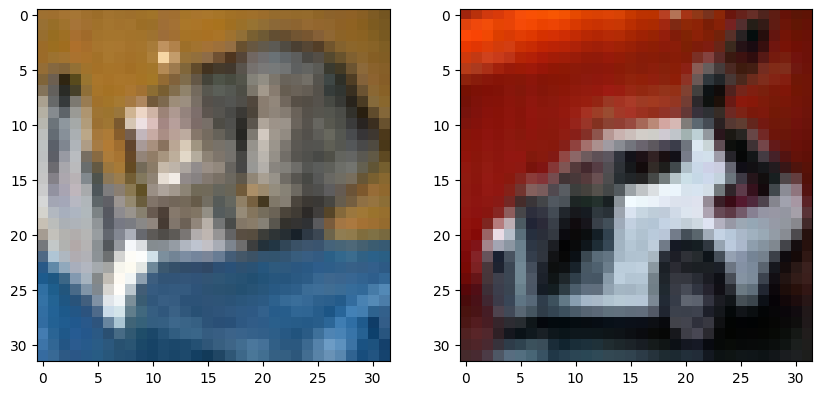

In [14]:
img1 = x_test[idx1]
img2 = x_test[idx2]

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(img1)
axes[1].imshow(img2)

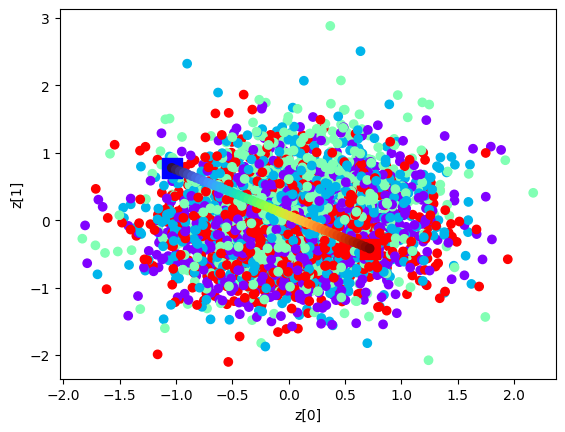

In [15]:
latent1 = z[idx1]
latent2 = z[idx2]

plt.scatter(z[:, 0], z[:, 1], c=y_test, cmap='rainbow')
plt.scatter(latent1[0], latent1[1], c='b', marker='s', s=200)
plt.scatter(latent2[0], latent2[1], c='r', marker='s', s=200)

n = 50
linear_space = np.linspace(latent1, latent2, n)
plt.scatter(linear_space[:, 0], linear_space[:, 1], c=np.linspace(0, 1, n), cmap='turbo')

plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


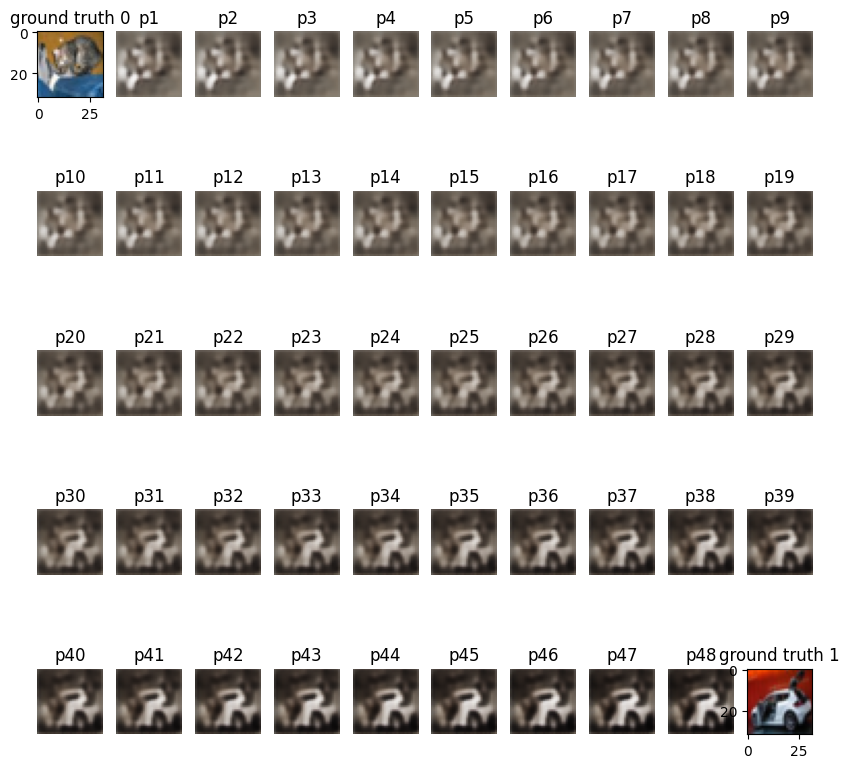

In [16]:
fig, axes = plt.subplots(5, 10, figsize=(10, 10))
axes[0][0].set_title('ground truth 0')
axes[0][0].imshow(img1)

axes[4][9].set_title('ground truth 1')
axes[4][9].imshow(img2)

linear_predictions = decoder.predict(linear_space)

for i in range(5):
    for j in range(10):
        if (i,j) == (0,0) or (i,j) == (4,9):
            continue
        axes[i][j].imshow(linear_predictions[i * 10 + j])
        axes[i][j].axis('off')
        axes[i][j].set_title('p' + str(i * 10 + j))